In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.translate.chrf_score import sentence_chrf, corpus_chrf
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming
from nltk.metrics.scores import recall

from basics import *

from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import time
import matplotlib.gridspec as gridspec
import importlib
from collections import namedtuple
import random
import json
import pandas as pd

%matplotlib inline

In [2]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [3]:
from nmt_run import *

In [4]:
cfg_path = "interspeech_bpe/sp_20hrs_best_bn-nobias_batch-32_buck-n25-w80"
dec_key = "bpe_w"

In [5]:
%%capture
last_epoch, model, optimizer, m_cfg, t_cfg = check_model(cfg_path)

In [6]:
%%capture
map_dict, vocab_dict, bucket_dict = get_data_dicts(m_cfg)

In [7]:
random.seed("meh")
# random.seed("haha")

In [8]:
def clean_out_str(out_str):
    out_str = out_str.replace("`", "")
    out_str = out_str.replace('"', '')
    out_str = out_str.replace('¿', '')
    out_str = out_str.replace("''", "")

    # for BPE
    out_str = out_str.replace("@@ ", "")
    out_str = out_str.replace("@@", "")

    out_str = out_str.strip()
    return out_str


# In[46]:


def get_out_str(word_list, dec_key="bpe_w"):
    h = [w.decode() for w in word_list]
    out_str = ""
    if dec_key == "en_w":
        for w in h:
            out_str += "{0:s}".format(w) if (w.startswith("'") or w=="n't") else " {0:s}".format(w)
    elif "bpe_w" in dec_key:
        out_str = " ".join(h)

    elif dec_key == "en_c":
        out_str = "".join(h)

    else:
        out_str = "".join(h)

    out_str = clean_out_str(out_str)
    return out_str

### Read predictions

In [9]:
dev_ids = []
with open("./fisher/fisher_dev/fisher_dev_eval.ids", "r", encoding="utf-8") as in_f:
    for line in in_f:
        dev_ids.append(line.strip())
     # end for
# end with

dev2_ids = []
with open("fisher/fisher_dev2/fisher_dev2_eval.ids", "r", encoding="utf-8") as in_f:
    for u in in_f:
        dev2_ids.append(u.strip())

In [10]:
google_s2t_hyps_path = os.path.join("../chainer2/speech2text/both_fbank_out/", "google_s2t_hyps.dict")
google_s2t_hyps = pickle.load(open(google_s2t_hyps_path, "rb"))
google_hyp_dev = google_s2t_hyps['fisher_dev_r0']

In [11]:
google_s2t_hyps_dev2 = pickle.load(open("./google/google_s2t_dev2_hyps.dict", "rb"))
google_hyp_dev2 = google_s2t_hyps_dev2['fisher_dev_r0']

In [12]:
model_pred_files = {
    "2.5h": "experiments/nmt_asr/sp-2.5hrs_swbd1-train_nodev_ep25_baseline",
    "2.5h+asr": "experiments/nmt_asr/sp-2.5hrs_swbd1-train_nodev_ep25",
    "5h": "experiments/nmt_asr/sp-5hrs_swbd1-train100k_baseline",
    "5h+asr": "experiments/nmt_asr/sp-5hrs_swbd1-train_nodev_ep25",
    "10h": "experiments/nmt_asr/sp-10hrs_swbd1-train100k_baseline",
    "10h+asr": "experiments/nmt_asr/sp-10hrs_swbd1-train_nodev_ep25_enc-attn-dec",
    "20h": "interspeech_bpe/sp_20hrs_best_bn-nobias_batch-32_buck-n25-w80/",
    "20h+asr": "experiments/nmt_asr/sp-20hrs_swbd1-train-nodev_ep25_enc-attn-dec/",
    "50h": "interspeech_bpe/sp_50hrs_best_bn-nobias_bucks-n25-w80_x0.2/",
    "50h+asr": "experiments/nmt_asr/sp-50hrs_swbd1-train-nodev_ep25/",
#     "160h": "interspeech_bpe/sp_160hrs_cnn-512-9-mfcc-13_drpt-0.3_l2e-4_rnn-3"
}

dev_beam_fname = "fisher_dev_beam_len-norm_min-0_max-300_N-5_K-5_W-0.6.en"
dev2_beam_fname = "fisher_dev2_beam_len-norm_min-0_max-300_N-5_K-5_W-0.6.en"

In [13]:
pred_dev_text = {}
pred_dev2_text = {}
for k, v in model_pred_files.items():
    pred_dev_text[k] = {}
    with open(os.path.join(v,dev_beam_fname), "r", encoding="utf-8") as in_f:
        for i, line in enumerate(in_f):
            utt = dev_ids[i]
            pred_dev_text[k][utt] = line.strip()
    
    pred_dev2_text[k] = {}
    with open(os.path.join(v,dev2_beam_fname), "r", encoding="utf-8") as in_f:
        for i, line in enumerate(in_f):
            utt = dev2_ids[i]
            pred_dev2_text[k][utt] = line.strip()
#         end for line
#     end with open
# end for

In [14]:
pred_dev_text["Weiss"] = {}
for utt in dev_ids:
    pred_dev_text["Weiss"][utt] = " ".join(google_hyp_dev[utt])

pred_dev2_text["Weiss"] = {}
for utt in dev2_ids:
    pred_dev2_text["Weiss"][utt] = " ".join(google_hyp_dev2[utt])

In [15]:
def get_text(set_key, ref_num=0, utts_list=set()):
    set_text = {}
    if len(utts_list) > 0:
        utts = set(map_dict[set_key]) & utts_list
    else:
        utts = map_dict[set_key].keys()
    for u in utts:
        if "train" in set_key:
            set_text[u] = get_out_str(map_dict[set_key][u]["bpe_w"])
        else:
            # fisher_dev has 4 references, but only 1 for BPE
            # modify logic if using en_w
            set_text[u] = get_out_str(map_dict[set_key][u]["en_w"][ref_num], "en_w")
    print(len(set_text))
    return set_text

In [16]:
def get_model_train_utts(model_path):
    buckets = pickle.load(open(os.path.join(model_path,"buckets_sp.dict"), "rb"))
    utts = []
    for b in buckets['fisher_train']['buckets']:
        utts.extend(b)
    utts = set(utts)
    return utts
        

In [17]:
train_utts = {}
for m, p in model_pred_files.items():
    train_utts[m] = get_model_train_utts(p)
    print("{0:10s} -- {1:10d}".format(m, len(train_utts[m])))

2.5h       --       2153
2.5h+asr   --       2153
5h         --       4323
5h+asr     --       4323
10h        --       8649
10h+asr    --       8649
20h        --      17306
20h+asr    --      17306
50h        --      46207
50h+asr    --      46207


In [18]:
base_models = ['2.5h', '5h', '10h', '20h', '50h']

In [19]:
train_text = {}
train_text["160h"] = get_text("fisher_train")
for m in base_models:
    train_text[m] = get_text("fisher_train", utts_list=train_utts[m])

138819
2153
4323
8649
17306
46207


In [20]:
dev_text = []
for i in range(4):
    dev_text.append(get_text("fisher_dev", ref_num=i))
list(dev_text[0].values())[:10]

3979
3979
3979
3979


['afternoon',
 'good afternoon',
 'my name is carmen in chicago you',
 'oh my name is ricardo',
 'of',
 "ah i'm in ah pennsylvania",
 'okay good afternoon',
 'well how are you good',
 'good thank god and you',
 "very good thank god as well it's very cold here is it very cold in chicago"]

In [21]:
dev2_text = []
for i in range(4):
    dev2_text.append(get_text("fisher_dev2", ref_num=i))
list(dev2_text[0].values())[:10]

3961
3961
3961
3961


['hi good af good evening',
 "good evening it's norma here from atlanta",
 "oh well would you look at that i'm from",
 "oh yeah we're we're near",
 "yes we're pretty close is this the first call you took",
 "yes because yesterday what happened is that since i was out they called me right the the computer called me but i wasn't here so couldn't",
 "i couldn't answer",
 "oh and i am on my cellphone they called me three times but i was at the store so i couldn't you know take ten minutes to talk",
 'sure',
 'but where are you from']

In [22]:
en_stop_words = set(nltk.corpus.stopwords.words("english"))

es_stop_words = set(nltk.corpus.stopwords.words("spanish"))

es_en_stop_words = en_stop_words | es_stop_words
len(en_stop_words), len(es_stop_words), len(es_en_stop_words)

(127, 313, 435)

In [23]:
def search_text(set_text, query_list, prog_bar=True):
    query_set = set([stem(q) for q in query_list])
    query_results = {q:[] for q in query_set}
    
    for u, v in tqdm(set_text.items(), ncols=100, disable=prog_bar):
        words_in_text = set([stem(w) for w in v.strip().split()])
        common_words = query_set & words_in_text
        for q in common_words:
            query_results[q].append(u)
            # end if query check
        # end for all query terms
    # end for all utterances
    return query_results
# end function

In [24]:
def get_common_ref_queries(dev_query_results):
    dev_common_results = {}
    for q in dev_query_results[0]:
        common_utts = set(dev_query_results[0][q])
        for i in range(1,4):
            common_utts &= set(dev_query_results[i][q])
        dev_common_results[q] = common_utts
    return dev_common_results

In [25]:
def get_query_terms_thresh(train_results, dev_common, dev2_common, min_c, max_c, max_terms):
    min_freq_dev_queries = [(q, dev_common[q], c, train_results["160h"][q]) for q,c in dev2_common.items() 
                            if len(c) >= min_c and len(c) <= max_c]
    print("{0:>5s} -- {1:20s} | {2:10s} | {3:10s} | {4:10s}".format("#", "query", 
                                                                    "dev count", "dev2_count", "train count"))
    min_freq_dev_queries = sorted(min_freq_dev_queries, key=lambda t:len(t[2]))
    if max_terms > 0:
        min_freq_dev_queries = min_freq_dev_queries[:max_terms]
    for i, (q, v, d2, t) in enumerate(min_freq_dev_queries, start=1):
        print("{0:>5d} -- {1:20s} | {2:10d} | {3:10d} | {4:10d}".format(i, q, len(v), len(d2), len(t)))
    return {q: {"train": t, "dev": d, "dev2": d2} for q, d, d2, t in min_freq_dev_queries}

### Topics

In [26]:
topics_fname = "../criseslex/fsp06_topics_in_english.txt"

In [27]:
topics = [ "peace", "Music", "Marriage", "Religion", "Cell phones", 
           "Dating", "Telemarketing and SPAM", "Politics", "Travel", 
           "Technical devices", "Healthcare", "Advertisements", "Power", 
           "Occupations", "Movies", "Welfare", "Breaking up", "Location", 
           "Justice", "Memories", "Crime", "Violence against women", "Equality", 
            "Housing", "Immigration",     
            # new topics
           "Interracial", "Christians", "muslims", "jews", "e-mail", 
           "phone", "democracy", "Democratic", "Republican", "technology", 
           "leadership", "community", "jury", "police", "inequality", 
           "renting", "Violence", "immigrants", "immigrant", "skilled", 
           "Telemarketing", "SPAM", "skill", "job", "health", "mobile", 
            "ads", "physical", "emotional", "bubble", "rent", "economy", 
            "abuse", "women", "city", "country", "suburban", "dollar", 
            "united states", "laws", "phone", "race", "biracial", "interracial", 
            "marriage", "lyrics", "sexuality", "medicine", "television", "european",
            "home", "protect", "spouse", "language", "cellphone", "money",
            "doctor", "insurance", "cigarettes", "alcohol", "income", "salary",
            "class", "censor", "rating", "programs", "government",
            "relationship", "legal", "event", "life", "safe", "victim", "cops",
            "wage", "illegal"
            ]
topics = list(set(t.lower() for t in topics))
topics_stem = [stem(t) for t in topics]
len(topics), len(topics_stem)

(98, 98)

In [28]:
topics_stem[:5]

['cop', 'salari', 'countri', 'program', 'telemarket']

In [29]:
topics_train_query_results = {}
for m in tqdm(train_text, ncols=80):
    topics_train_query_results[m] = search_text(train_text[m], topics)

100%|█████████████████████████████████████████████| 6/6 [00:37<00:00,  6.26s/it]


In [30]:
topics_dev_query_results = []
for i in range(4):
    topics_dev_query_results.append(search_text(dev_text[i], topics))    

In [31]:
topics_dev2_query_results = []
for i in range(4):
    topics_dev2_query_results.append(search_text(dev2_text[i], topics))    

In [32]:
# all_dev_counts = [(q, [len(topics_dev_query_results[i][q]) for i in range(4)]) for q in topics_train_query_results]

In [33]:
topics_dev_common = get_common_ref_queries(topics_dev_query_results)

In [34]:
topics_dev2_common = get_common_ref_queries(topics_dev2_query_results)

In [35]:
topic_query_terms = get_query_terms_thresh(topics_train_query_results, 
                                           topics_dev_common, topics_dev2_common, 3, 20, max_terms=25)

    # -- query                | dev count  | dev2_count | train count
    1 -- memori               |          0 |          3 |        109
    2 -- incom                |          1 |          3 |         39
    3 -- technolog            |          0 |          3 |        236
    4 -- christian            |          6 |          3 |        248
    5 -- rent                 |          3 |          3 |        330
    6 -- communiti            |          2 |          4 |        105
    7 -- program              |         11 |          4 |        357
    8 -- date                 |          1 |          4 |        307
    9 -- job                  |          3 |          6 |        634
   10 -- women                |          3 |          6 |        542
   11 -- languag              |          3 |          7 |        299
   12 -- republican           |          1 |          7 |         75
   13 -- telemarket           |          0 |          7 |         79
   14 -- citi                 |  

In [36]:
topics_train_freqs = {}
for q in topic_query_terms:
    topics_train_freqs[q] = {}
    for m in topics_train_query_results:
        topics_train_freqs[q][m] = len(topics_train_query_results[m][q])

In [37]:
topics_freq_df = pd.DataFrame.from_dict(topics_train_freqs, orient='index')

In [38]:
topics_freq_df

,160h,2.5h,5h,10h,20h,50h
christian,248,7,12,19,42,83
citi,1190,23,37,79,151,400
communiti,105,2,4,12,20,40
date,307,4,8,16,36,80
democrat,87,1,2,2,6,34
dollar,543,8,19,37,71,197
govern,357,4,8,19,32,121
home,555,6,11,32,66,170
hous,1380,22,47,97,189,475
incom,39,1,0,2,4,13


In [39]:
print(sum([1 if len(d["dev"]) > 0 else 0 for d in topic_query_terms.values()]))
print(np.sum([len(d["dev"]) for d in topic_query_terms.values()]))
print(sum([1 if len(d["dev2"]) > 0 else 0 for d in topic_query_terms.values()]))
print(np.sum([len(d["dev2"]) for d in topic_query_terms.values()]))

21
199
25
207


### Evaluation

In [40]:
topics_pred_dev_results = {}
topics_pred_dev2_results = {}
for k in pred_dev_text:
    topics_pred_dev_results[k] = search_text(pred_dev_text[k], topic_query_terms)
    topics_pred_dev2_results[k] = search_text(pred_dev2_text[k], topic_query_terms)

In [41]:
def compute_prec_recall(query_docs, pred_docs, set_key):
    query_matches = {}
    aggregate_results = {"t": 0, "tp": 0, "tc": 0}
    for i, q in enumerate(query_docs):
        pred_set = set(pred_docs[q])
        query_matches[q] = {}
        query_matches[q]["t"] = len(query_docs[q][set_key])
        query_matches[q]["tp"] = len(pred_set)
        query_matches[q]["tc"] = len(pred_set & query_docs[q][set_key])
        query_matches[q]["prec"] = query_matches[q]["tc"] / query_matches[q]["tp"] if query_matches[q]["tp"] > 0 else 0
        query_matches[q]["rec"] = query_matches[q]["tc"] / query_matches[q]["t"] if query_matches[q]["t"] > 0 else 0
    
    for q in query_matches:
        for k in aggregate_results:
            aggregate_results[k] += query_matches[q][k]
            
    aggregate_results["prec"] = aggregate_results["tc"] / aggregate_results["tp"] if aggregate_results["tp"] > 0 else 0
    aggregate_results["rec"] = aggregate_results["tc"] / aggregate_results["t"] if aggregate_results["t"] > 0 else 0
    
    return query_matches, aggregate_results
        

In [42]:
def evaluate_preds(query_terms, eval_matches, set_key):
    eval_results = {}
    print("{0:10s} | {1:10s}% | {2:10s}%".format("model", "precision", "recall"))
    for k in eval_matches:
        eval_results[k] = {}
        eval_results[k]["query"], eval_results[k]["aggr"] = compute_prec_recall(query_terms, eval_matches[k], set_key)
        print("{0:10s} | {1:10.1f} | {2:10.1f}".format(k, eval_results[k]["aggr"]["prec"]*100, eval_results[k]["aggr"]["rec"]*100))
    return eval_results
    

In [43]:
topics_dev_eval = evaluate_preds(topic_query_terms, topics_pred_dev_results, "dev")

model      | precision % | recall    %
2.5h       |        1.2 |        0.5
2.5h+asr   |        7.5 |       12.6
5h         |        0.0 |        0.0
5h+asr     |       19.0 |       22.6
10h        |        2.5 |        2.5
10h+asr    |       24.1 |       38.7
20h        |       25.0 |       31.7
20h+asr    |       34.8 |       53.3
50h        |       44.7 |       61.3
50h+asr    |       49.6 |       70.9
Weiss      |       60.7 |       91.0


In [44]:
topics_dev2_eval = evaluate_preds(topic_query_terms, topics_pred_dev2_results, "dev2")

model      | precision % | recall    %
2.5h       |        1.1 |        0.5
2.5h+asr   |        3.6 |        5.3
5h         |        0.0 |        0.0
5h+asr     |       13.5 |       13.5
10h        |        0.5 |        0.5
10h+asr    |       26.8 |       34.8
20h        |       23.4 |       24.2
20h+asr    |       38.3 |       47.3
50h        |       41.9 |       54.1
50h+asr    |       47.7 |       60.4
Weiss      |       61.8 |       85.0


In [45]:
topics_pred_dev_results["20h+asr"].keys()

dict_keys(['rent', 'dollar', 'hous', 'job', 'citi', 'life', 'spam', 'law', 'christian', 'technolog', 'languag', 'program', 'home', 'marriag', 'republican', 'memori', 'democrat', 'telemarket', 'date', 'polit', 'communiti', 'govern', 'incom', 'religion', 'women'])

### Crisis words

In [46]:
crisis_lex_fname = "../criseslex/CrisisLexLexicon/CrisisLexRec.txt"

In [47]:
crisis = set()
with open(crisis_lex_fname, "r") as in_f:
    for line in in_f:
        crisis.update(line.strip().split())
crisis = list(crisis)
crisis_stem = [stem(w) for w in crisis]

In [48]:
len(crisis_stem)

288

In [49]:
crisis_train_query_results = {}
for m in train_text:
    crisis_train_query_results[m] = search_text(train_text[m], crisis)

In [50]:
crisis_dev_query_results = []
for i in range(4):
    crisis_dev_query_results.append(search_text(dev_text[i], crisis))    

In [51]:
crisis_dev2_query_results = []
for i in range(4):
    crisis_dev2_query_results.append(search_text(dev2_text[i], crisis))    

In [52]:
crisis_pred_dev_results = {}
crisis_pred_dev2_results = {}
for k in pred_dev_text:
    crisis_pred_dev_results[k] = search_text(pred_dev_text[k], crisis)
    crisis_pred_dev2_results[k] = search_text(pred_dev2_text[k], crisis)

In [53]:
crisis_dev_common = get_common_ref_queries(crisis_dev_query_results)

In [54]:
crisis_dev2_common = get_common_ref_queries(crisis_dev2_query_results)

In [55]:
crisis_query_terms = get_query_terms_thresh(crisis_train_query_results, 
                                           crisis_dev_common, crisis_dev2_common, 5, 20, max_terms=25)

    # -- query                | dev count  | dev2_count | train count
    1 -- free                 |          5 |          5 |        263
    2 -- count                |          0 |          5 |        105
    3 -- high                 |          5 |          5 |        266
    4 -- love                 |         19 |          5 |        879
    5 -- women                |          3 |          6 |        542
    6 -- servic               |          6 |          7 |        227
    7 -- hundr                |          3 |          7 |        561
    8 -- citi                 |         33 |          8 |       1190
    9 -- chang                |         21 |          8 |        785
   10 -- thousand             |          6 |          8 |        454
   11 -- someon               |         10 |          8 |       1014
   12 -- anoth                |          9 |          8 |       1215
   13 -- come                 |         14 |          8 |       1774
   14 -- emerg                |  

In [56]:
crisis_train_freqs = {}
for q in crisis_query_terms:
    crisis_train_freqs[q] = {}
    for m in crisis_train_query_results:
        crisis_train_freqs[q][m] = len(crisis_train_query_results[m][q])

In [57]:
crisis_freq_df = pd.DataFrame.from_dict(crisis_train_freqs, orient='index')

In [58]:
crisis_freq_df

,160h,2.5h,5h,10h,20h,50h
anoth,1215,19,35,71,143,393
chang,785,12,27,66,116,268
citi,1190,23,37,79,151,400
come,1774,36,62,106,227,610
count,105,1,2,11,15,42
emerg,108,1,6,11,20,34
find,1049,12,28,55,115,348
first,939,17,26,52,106,297
free,263,3,7,13,29,99
girl,748,7,16,33,70,241


In [59]:
print(sum([1 if len(d["dev"]) > 0 else 0 for d in crisis_query_terms.values()]))
print(np.sum([len(d["dev"]) for d in crisis_query_terms.values()]))
print(sum([1 if len(d["dev2"]) > 0 else 0 for d in crisis_query_terms.values()]))
print(np.sum([len(d["dev2"]) for d in crisis_query_terms.values()]))

23
226
25
202


In [60]:
crisis_dev_eval = evaluate_preds(crisis_query_terms, crisis_pred_dev_results, "dev")

model      | precision % | recall    %
2.5h       |        1.0 |        0.4
2.5h+asr   |        7.9 |        9.7
5h         |        2.0 |        0.4
5h+asr     |       16.7 |       19.0
10h        |        3.0 |        1.8
10h+asr    |       26.4 |       32.7
20h        |       25.3 |       24.8
20h+asr    |       33.7 |       45.6
50h        |       35.9 |       51.3
50h+asr    |       41.7 |       58.8
Weiss      |       47.1 |       82.7


In [61]:
crisis_dev2_eval = evaluate_preds(crisis_query_terms, crisis_pred_dev2_results, "dev2")

model      | precision % | recall    %
2.5h       |        1.0 |        0.5
2.5h+asr   |        3.8 |        5.4
5h         |        2.3 |        0.5
5h+asr     |       11.6 |       16.8
10h        |        0.0 |        0.0
10h+asr    |       23.1 |       27.7
20h        |       15.6 |       14.4
20h+asr    |       31.6 |       41.1
50h        |       30.9 |       46.5
50h+asr    |       34.5 |       54.5
Weiss      |       39.9 |       81.2


In [62]:
crisis_dev2_eval["20h+asr"]['query'].keys()

dict_keys(['free', 'count', 'high', 'love', 'women', 'servic', 'hundr', 'citi', 'chang', 'thousand', 'someon', 'anoth', 'come', 'emerg', 'second', 'girl', 'govern', 'find', 'thought', 'hous', 'number', 'leav', 'million', 'first', 'need'])

In [63]:
# crisis_dev2_eval["50h+asr"]

### Plots

In [64]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [65]:
sns.set_style("whitegrid", {"axes.grid": True})

In [66]:
dcolors = [(215,25,28),
            (253,174,97),
            (255,255,191),
            (171,221,164),
            (43,131,186)]
for i in range(len(dcolors)):    
    r, g, b = dcolors[i]    
    dcolors[i] = (r / 255., g / 255., b / 255.)

In [67]:
hrs = [2.5, 5, 10, 20, 50, 160]
x_scale = np.array(hrs)
x_labels = [str(i)+"h" for i in hrs]
# x_points = np.linspace(0, 100, len(x_scale))
x_points = np.array([math.log(i) for i in hrs])

prec_base = np.array([topics_dev2_eval[i]["aggr"]["prec"] * 100 for i in x_labels[:-1]])
prec_asr = np.array([topics_dev2_eval[i+"+asr"]["aggr"]["prec"] * 100 for i in x_labels[:-1]])
rec_base = np.array([topics_dev2_eval[i]["aggr"]["rec"] * 100 for i in x_labels[:-1]])
rec_asr = np.array([topics_dev2_eval[i+"+asr"]["aggr"]["rec"] * 100 for i in x_labels[:-1]])

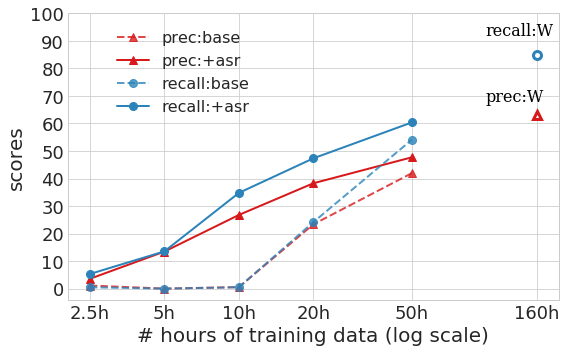

In [68]:
fig, ax = plt.subplots(figsize=(8,5),nrows=1, ncols=1, sharey=True)

markersize = 8
linewidth = 2
alpha = 1

ax.plot(x_points[:-1], prec_base, label="prec:base", color=dcolors[0], 
        linewidth=linewidth, marker='^', 
        markersize=markersize, linestyle="--", alpha=0.8)

ax.plot(x_points[:-1], prec_asr, label="prec:+asr", color=dcolors[0], 
        linewidth=linewidth, marker='^', markersize=markersize, linestyle="-")

ax.plot(x_points[:-1], rec_base, label="recall:base", color=dcolors[4], 
        linewidth=linewidth, marker='o', markersize=markersize, linestyle="--", alpha=0.8)

ax.plot(x_points[:-1], rec_asr, label="recall:+asr", color=dcolors[4], 
        linewidth=linewidth, marker='o', markersize=markersize, linestyle="-")

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

# ax.axhline(y=21, linestyle=":", color='k')
# plt.text(75, 23, r'naive baseline', fontdict=font)

ax.plot(x_points[-1:], np.array([63]), color=dcolors[0],
        marker='^', markersize=markersize, markerfacecolor="w", markeredgewidth=3)
plt.text(4.6, 68, r'prec:W', fontdict=font)
ax.plot(x_points[-1:], np.array([85]), color=dcolors[4],
        marker='o', markersize=markersize, markerfacecolor="w", markeredgewidth=3)
plt.text(4.6, 92, r'recall:W', fontdict=font)


plt.xticks(x_points, x_labels, rotation=0, fontsize=18)
# plt.yticks(list(range(0,65,10))+[76, 71, ], rotation=0, fontsize=20)
plt.yticks(list(range(0,101,10)), rotation=0, fontsize=20)
ax.set_xlabel('# hours of training data (log scale)', size=20)
ax.set_ylabel('scores', size=20)
for i in ax.get_xticklabels():
    i.set_fontsize(18)
for i in ax.get_yticklabels():
    i.set_fontsize(18)

plt.legend(bbox_to_anchor=(0.4, 0.99), framealpha=0, fontsize=16, ncol=1)
# plt.ylim(0,100)
# plt.xlim(1,101)
# ax.xaxis.grid(False)

# sns.despine(left=True, bottom=True)

fig.tight_layout()

# fig.savefig(fname="./figs/kws_prec_rec.pdf", dpi=300)
# fig.savefig(fname="./figs/kws_prec_rec.png", dpi=300)

In [69]:
hrs = [2.5, 5, 10, 20, 50, 160]
x_scale = np.array(hrs)
x_labels = [str(i)+"h" for i in hrs]
# x_points = np.linspace(0, 100, len(x_scale))
x_points = np.array([math.log(i) for i in hrs])

prec_base = np.array([crisis_dev2_eval[i]["aggr"]["prec"] * 100 for i in x_labels[:-1]])
prec_asr = np.array([crisis_dev2_eval[i+"+asr"]["aggr"]["prec"] * 100 for i in x_labels[:-1]])
rec_base = np.array([crisis_dev2_eval[i]["aggr"]["rec"] * 100 for i in x_labels[:-1]])
rec_asr = np.array([crisis_dev2_eval[i+"+asr"]["aggr"]["rec"] * 100 for i in x_labels[:-1]])

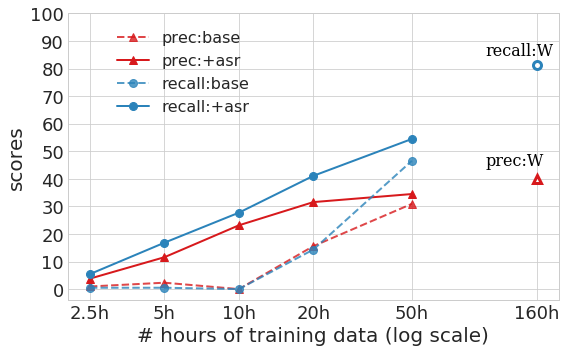

In [70]:
fig, ax = plt.subplots(figsize=(8,5),nrows=1, ncols=1, sharey=True)

markersize = 8
linewidth = 2
alpha = 1

ax.plot(x_points[:-1], prec_base, label="prec:base", color=dcolors[0], 
        linewidth=linewidth, marker='^', 
        markersize=markersize, linestyle="--", alpha=0.8)

ax.plot(x_points[:-1], prec_asr, label="prec:+asr", color=dcolors[0], 
        linewidth=linewidth, marker='^', markersize=markersize, linestyle="-")

ax.plot(x_points[:-1], rec_base, label="recall:base", color=dcolors[4], 
        linewidth=linewidth, marker='o', markersize=markersize, linestyle="--", alpha=0.8)

ax.plot(x_points[:-1], rec_asr, label="recall:+asr", color=dcolors[4], 
        linewidth=linewidth, marker='o', markersize=markersize, linestyle="-")

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

# ax.axhline(y=21, linestyle=":", color='k')
# plt.text(75, 23, r'naive baseline', fontdict=font)

ax.plot(x_points[-1:], np.array([39.9]), color=dcolors[0],
        marker='^', markersize=markersize, markerfacecolor="w", markeredgewidth=3)
plt.text(4.6, 45, r'prec:W', fontdict=font)
ax.plot(x_points[-1:], np.array([81.2]), color=dcolors[4],
        marker='o', markersize=markersize, markerfacecolor="w", markeredgewidth=3)
plt.text(4.6, 85, r'recall:W', fontdict=font)


plt.xticks(x_points, x_labels, rotation=0, fontsize=18)
# plt.yticks(list(range(0,65,10))+[76, 71, ], rotation=0, fontsize=20)
plt.yticks(list(range(0,101,10)), rotation=0, fontsize=20)
ax.set_xlabel('# hours of training data (log scale)', size=20)
ax.set_ylabel('scores', size=20)
for i in ax.get_xticklabels():
    i.set_fontsize(18)
for i in ax.get_yticklabels():
    i.set_fontsize(18)

plt.legend(bbox_to_anchor=(0.4, 0.99), framealpha=0, fontsize=16, ncol=1)
# plt.ylim(0,100)
# plt.xlim(1,101)
# ax.xaxis.grid(False)

# sns.despine(left=True, bottom=True)

fig.tight_layout()

# fig.savefig(fname="./figs/kws_prec_rec.pdf", dpi=300)
# fig.savefig(fname="./figs/kws_prec_rec.png", dpi=300)